In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy, json
# from tqdm.autonotebook import tqdm
from tqdm import tqdm

In [2]:
import torch.optim as optim
from torch.utils import data

In [3]:
from transformers_lib import TransformerBlock, \
        Mixer_TransformerBlock_Encoder, \
        PositionalEncoding

In [4]:
class TinyImageNet_Preload(data.Dataset):
#     https://gist.github.com/z-a-f/b862013c0dc2b540cf96a123a6766e54
    
    def __init__(self, root, mode='train', transform=None, preload=False):
        super().__init__()
        self.preload = preload
        dataset = datasets.ImageFolder(
            root=os.path.join(root, mode),
            transform=None
        )
        self.transform = transform
        self.images, self.labels = [], []
        print("Dataset Size:",len(dataset))
        
        if preload:
            for i in tqdm(range(len(dataset))):
                x, y = dataset[i]
                self.images.append(x)
                self.labels.append(y)
                
#         del dataset
        self.dataset = dataset
            
    def _add_channels(img, total_channels=3):
        while len(img.shape) < 3:  # third axis is the channels
            img = np.expand_dims(img, axis=-1)
        while(img.shape[-1]) < 3:
            img = np.concatenate([img, img[:, :, -1:]], axis=-1)
        return img
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        if self.preload:
            img, lbl = self.images[idx], self.labels[idx]
        else:
            img, lbl = self.dataset[idx]
        return self.transform(img), lbl

# Model

In [5]:
class Mixer_ViT_Classifier(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_size:tuple, hidden_channel:int, num_blocks:int, num_classes:int, block_seq_size:int, block_mlp_size:int, forward_expansion:float=2.0, pos_emb=True, dropout:float=0.0):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W) or (H, W)
        
        ### find patch dim
        d0 = int(image_dim[-2]/patch_size[0])
        d1 = int(image_dim[-1]/patch_size[1])
        assert d0*patch_size[0]==image_dim[-2], "Image must be divisible into patch size"
        assert d1*patch_size[1]==image_dim[-1], "Image must be divisible into patch size"
        
#         self.d0, self.d1 = d0, d1 ### number of patches in each axis
        __patch_size = patch_size[0]*patch_size[1]*image_dim[0] ## number of channels in each patch
    
        ### find channel dim
        channel_size = d0*d1 ## number of patches
        
        ### after the number of channels are changed
        init_dim = __patch_size
        final_dim = hidden_channel
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        #### rescale the patches (patch wise image non preserving transform, unlike bilinear interpolation)
        self.channel_change = nn.Linear(init_dim, final_dim)
        print(f"ViT Mixer : Channels per patch -> Initial:{init_dim} Final:{final_dim}")
        
        
        self.channel_dim = final_dim
        self.patch_dim = channel_size
        
        self.transformer_blocks = []
        
        f = self.get_factors(self.channel_dim)
        print(f)
        fi = np.abs(np.array(f) - np.sqrt(self.channel_dim)).argmin()
        
        _n_heads = f[fi]
        
        ## number of dims per channel -> channel_dim
#         print('Num patches:', self.patch_dim)
        print(f'Sequence len: {self.patch_dim} ; Block size: {block_seq_size}')
        print('Channel dim:', self.channel_dim, 'num heads:',_n_heads)
        
        if block_seq_size is None or block_seq_size<2:
            ### Find the block size for sequence:
            block_seq_size = int(2**np.ceil(np.log2(np.sqrt(self.patch_dim))))
            
        print(f'MLP dim: {self.channel_dim} ; Block size: {block_mlp_size}')

        for i in range(num_blocks):
            L = Mixer_TransformerBlock_Encoder(self.patch_dim, block_seq_size, self.channel_dim, _n_heads, dropout, forward_expansion, nn.GELU, block_mlp_size)
            self.transformer_blocks.append(L)
        self.transformer_blocks = nn.Sequential(*self.transformer_blocks)
        
        self.linear = nn.Linear(self.patch_dim*self.channel_dim, num_classes)
        
        self.positional_encoding = PositionalEncoding(self.channel_dim, dropout=0)
        if not pos_emb:
            self.positional_encoding = nn.Identity()
        
        
    def get_factors(self, n):
        facts = []
        for i in range(2, n+1):
            if n%i == 0:
                facts.append(i)
        return facts
    
    def forward(self, x):
        bs = x.shape[0]
        x = self.unfold(x).swapaxes(-1, -2)
        x = self.channel_change(x)
        x = self.positional_encoding(x)
        x = self.transformer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [6]:
def benchmark(dataset:str, patch_size:int, num_layers:int, SEED:int, sparse_att:bool=False, sparse_mlp:bool=False, cuda:int=0):
    device = torch.device(f"cuda:{cuda}")
    
    if sparse_att:
        assert num_layers%2 == 0, 'number of blocks on sparse transformer is (x2)/2 hence it must be even'
        num_layers_ = num_layers//2
    else:
        num_layers_ = num_layers
    
    BS = 256
    NC = -1
    EPOCHS = 300
    imsize = (3, 32, 32)
    expansion_dict = {16:1024, 8:256, 4:128, 2:64, 1:64}
    expansion = expansion_dict[patch_size]

    
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    ##### Data Transforms
    if dataset == 'tiny':
        NC = 200
        EPOCHS = 400
        imsize = (3, 64, 64)
        tiny_train = transforms.Compose([
        transforms.RandAugment(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5]*3,
            std=[0.2]*3,
            ),
        ])

        tiny_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5]*3,
                std=[0.2]*3,
            ),
        ])
        
        train_dataset = TinyImageNet_Preload(root="../../../../../_Datasets/tiny-imagenet-200",
                                     mode='train', transform=tiny_train)
        test_dataset = TinyImageNet_Preload(root="../../../../../_Datasets/tiny-imagenet-200",
                                     mode='val', transform=tiny_test)
        
    elif dataset == 'cifar10':
        NC = 10
        BS = 32
        cifar_train = transforms.Compose([
            transforms.RandomCrop(size=32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
                std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
            ),
        ])

        cifar_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
                std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
            ),
        ])

        train_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
        test_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

    elif dataset == 'cifar100':
        NC = 100
        BS = 128
        cifar_train = transforms.Compose([
            transforms.RandomCrop(size=32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5071, 0.4865, 0.4409],
                std=[0.2009, 0.1984, 0.2023],
            ),
        ])

        cifar_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5071, 0.4865, 0.4409],
                std=[0.2009, 0.1984, 0.2023],
            ),
        ])

        train_dataset = datasets.CIFAR100(root="../../../../../_Datasets/cifar100/", train=True, download=True, transform=cifar_train)
        test_dataset = datasets.CIFAR100(root="../../../../../_Datasets/cifar100/", train=False, download=True, transform=cifar_test)
        
    ##### Now create data loaders
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BS, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BS, shuffle=False, num_workers=4)
    
    ### Now create models
    
    seq_len = (imsize[-1]*imsize[-2])//(patch_size*patch_size)
    mlp_dim = expansion
    print(seq_len, mlp_dim)
    
    if sparse_att:
        seq_len = int(2**np.ceil(np.log2(np.sqrt(seq_len))))
    if sparse_mlp:
        mlp_dim = int(2**np.ceil(np.log2(np.sqrt(expansion))))
    
    
    torch.manual_seed(SEED)
    model = Mixer_ViT_Classifier(imsize, 
                                 patch_size=[patch_size]*2, 
                                 hidden_channel=expansion, 
                                 num_blocks=num_layers_, 
                                 num_classes=NC, 
                                 block_seq_size=seq_len, 
                                 block_mlp_size=mlp_dim).to(device)
    
#     _x = torch.randn(BS, *imsize).to(device)
#     print("Output: ",vit_mixer(_x).shape)
    num_params = sum(p.numel() for p in model.parameters())
    print("number of params: ", num_params)
    
    _a, _b = 'att', 'mlp'
    if sparse_att: _a = 'sAtt'
    if sparse_mlp: _a = 'sMlp'
    model_name = f'01.3_ViT_{dataset}_patch{patch_size}_l{num_layers}_{_a}_{_b}_s{SEED}'
    print(f"Model Name: {model_name}")
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    STAT ={'train_stat':[], 'test_stat':[], 'params':num_params, }

    ## Following is copied from 
    ### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

    # Training
    def train(epoch):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            break

        STAT['train_stat'].append((epoch, train_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
        print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
        return

    global best_acc
    best_acc = -1
    def test(epoch):
        global best_acc
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        time_taken = []
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
                inputs, targets = inputs.to(device), targets.to(device)

                start = time.time()

                outputs = model(inputs)

                start = time.time()-start
                time_taken.append(start)

                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        STAT['test_stat'].append((epoch, test_loss/(batch_idx+1), 100.*correct/total, np.mean(time_taken))) ### (Epochs, Loss, Acc, time)
        print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")

        # Save checkpoint.
        acc = 100.*correct/total
        if acc > best_acc:
            print('Saving..')
            state = {
                'model': model.state_dict(),
                'acc': acc,
                'epoch': epoch
            }
            if not os.path.isdir('models'):
                os.mkdir('models')
            torch.save(state, f'./models/benchmark/{model_name}.pth')
            best_acc = acc

        with open(f"./output/benchmark/{model_name}_data.json", 'w') as f:
            json.dump(STAT, f, indent=0)

    ### Train the whole damn thing
    EPOCHS = 1
    for epoch in range(0, EPOCHS):
        train(epoch)
        test(epoch)
        scheduler.step()
        
    
    train_stat = np.array(STAT['train_stat'])
    test_stat = np.array(STAT['test_stat'])

    plt.plot(train_stat[:,1], label='train')
    plt.plot(test_stat[:,1], label='test')
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"./output/benchmark/plots/{model_name}_loss.svg")
    plt.show()

    plt.plot(train_stat[:,2], label='train')
    plt.plot(test_stat[:,2], label='test')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"./output/benchmark/plots/{model_name}_accs.svg")
    plt.show()
    
    del model, optimizer
    return

In [7]:
# benchmark(dataset='tiny', 
#           patch_size=4, num_layers=10, SEED=123, sparse_att=True, sparse_mlp=True, cuda=0
#          )

In [8]:
# ### Automate the benchmark
# ###### for tiny
# cuda_idx = 0
# # for seed in [147, 258, 369]:
# for seed in [147]:
#     for patch_size in [16, 8, 4]:
#         for sparse_attention in [False, True]:
#             for sparse_mlp in [False, True]:
# #                 for nlayers in [6, 10, 14]:
#                 for nlayers in [6]:
#                     print(f'''
#                         Experimenting on Tiny Dataset 
#                         patch:{patch_size},
#                         sparse_att: {sparse_attention},
#                         sparse_mlp: {sparse_mlp},
#                         num_layers : {nlayers},
#                         seed: {seed}
#                     ''')
            
#                     benchmark(dataset='tiny', 
#                               patch_size=patch_size, 
#                               num_layers=nlayers, 
#                               SEED=seed, 
#                               sparse_att=sparse_attention, sparse_mlp=sparse_mlp, 
#                               cuda=cuda_idx
#                              )


In [9]:
# ### Automate the benchmark
# ###### for tiny

# not_working = [
#     (4, False, True, 6),
#     (4, False, False, 10),
#     (4, False, False, 14),
#     (4, False, True, 10),
#     (4, False, True, 14),
#     (4, True, True, 14),
# ]

# cuda_idx = 0
# # for seed in [147, 258, 369]:
# for seed in [147]:
#     for patch_size in [16, 8, 4]:
#         for sparse_attention in [False, True]:
#             for sparse_mlp in [False, True]:
#                 for nlayers in [6, 10, 14]:

#                     print(f'''
#                         Experimenting on Tiny Dataset 
#                         patch:{patch_size},
#                         sparse_att: {sparse_attention},
#                         sparse_mlp: {sparse_mlp},
#                         num_layers : {nlayers},
#                         seed: {seed}
#                     ''')
            
#                 ### check if config is in not_working case
#                     exit = False
#                     for nw in not_working:
#                         if patch_size==nw[0] and \
#                             sparse_attention==nw[1] and \
#                             sparse_mlp==nw[2] and\
#                             nlayers==nw[3]:
                            
#                             exit=True
#                             break
#                     if exit:
#                         print(f'Exiting as the config is in NOT WORKING')
#                         continue


#                     benchmark(dataset='tiny', 
#                               patch_size=patch_size, 
#                               num_layers=nlayers, 
#                               SEED=seed, 
#                               sparse_att=sparse_attention, sparse_mlp=sparse_mlp, 
#                               cuda=cuda_idx
#                              )



                        Experimenting on Tiny Dataset 
                        patch:1,
                        sparse_att: False,
                        sparse_mlp: False,
                        num_layers : 4,
                        seed: 147
                    
Exiting as the config is in NOT WORKING

                        Experimenting on Tiny Dataset 
                        patch:1,
                        sparse_att: False,
                        sparse_mlp: False,
                        num_layers : 8,
                        seed: 147
                    
Exiting as the config is in NOT WORKING

                        Experimenting on Tiny Dataset 
                        patch:1,
                        sparse_att: False,
                        sparse_mlp: False,
                        num_layers : 12,
                        seed: 147
                    
Exiting as the config is in NOT WORKING

                        Experimenting on Tiny Dataset 
             

  0%|                                                             | 0/391 [00:00<?, ?it/s]


[Train] 0 Loss: 4.804 | Acc: 3.125 4/128


100%|█████████████████████████████████████████████████████| 79/79 [00:06<00:00, 11.34it/s]


[Test] 0 Loss: 6.061 | Acc: 2.800 280/10000
Saving..


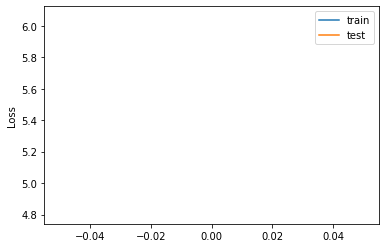

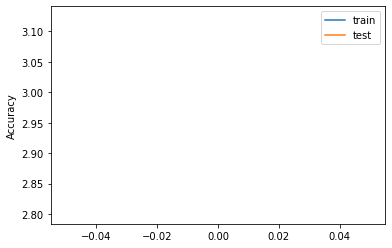


                        Experimenting on Tiny Dataset 
                        patch:1,
                        sparse_att: True,
                        sparse_mlp: False,
                        num_layers : 8,
                        seed: 147
                    
Files already downloaded and verified
Files already downloaded and verified
1024 64
ViT Mixer : Channels per patch -> Initial:3 Final:64
[2, 4, 8, 16, 32, 64]
Sequence len: 1024 ; Block size: 32
Channel dim: 64 num heads: 8
MLP dim: 64 ; Block size: 64
number of params:  6821732
Model Name: 01.3_ViT_cifar100_patch1_l8_sAtt_mlp_s147


  0%|                                                             | 0/391 [00:00<?, ?it/s]


[Train] 0 Loss: 4.838 | Acc: 0.781 1/128


100%|█████████████████████████████████████████████████████| 79/79 [00:13<00:00,  5.83it/s]


[Test] 0 Loss: 6.165 | Acc: 1.950 195/10000
Saving..


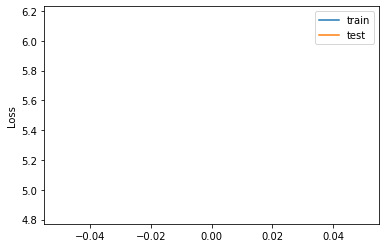

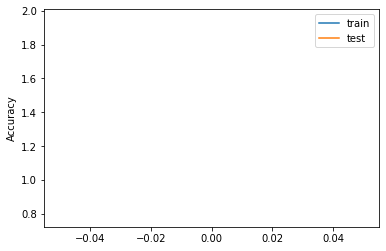


                        Experimenting on Tiny Dataset 
                        patch:1,
                        sparse_att: True,
                        sparse_mlp: False,
                        num_layers : 12,
                        seed: 147
                    
Exiting as the config is in NOT WORKING

                        Experimenting on Tiny Dataset 
                        patch:1,
                        sparse_att: True,
                        sparse_mlp: True,
                        num_layers : 4,
                        seed: 147
                    
Files already downloaded and verified
Files already downloaded and verified
1024 64
ViT Mixer : Channels per patch -> Initial:3 Final:64
[2, 4, 8, 16, 32, 64]
Sequence len: 1024 ; Block size: 32
Channel dim: 64 num heads: 8
MLP dim: 64 ; Block size: 8
number of params:  6639460
Model Name: 01.3_ViT_cifar100_patch1_l4_sMlp_mlp_s147


  0%|                                                             | 0/391 [00:00<?, ?it/s]


[Train] 0 Loss: 4.769 | Acc: 1.562 2/128


100%|█████████████████████████████████████████████████████| 79/79 [00:08<00:00,  9.62it/s]


[Test] 0 Loss: 7.645 | Acc: 1.530 153/10000
Saving..


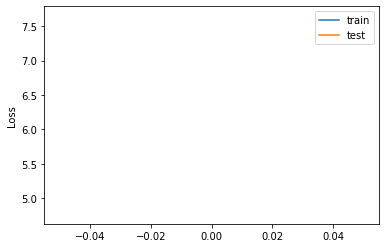

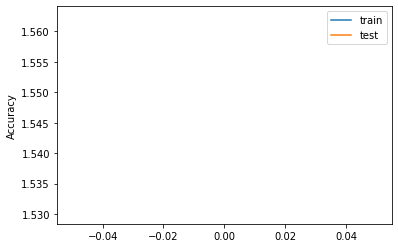


                        Experimenting on Tiny Dataset 
                        patch:1,
                        sparse_att: True,
                        sparse_mlp: True,
                        num_layers : 8,
                        seed: 147
                    
Files already downloaded and verified
Files already downloaded and verified
1024 64
ViT Mixer : Channels per patch -> Initial:3 Final:64
[2, 4, 8, 16, 32, 64]
Sequence len: 1024 ; Block size: 32
Channel dim: 64 num heads: 8
MLP dim: 64 ; Block size: 8
number of params:  6724964
Model Name: 01.3_ViT_cifar100_patch1_l8_sMlp_mlp_s147


  0%|                                                             | 0/391 [00:00<?, ?it/s]


[Train] 0 Loss: 4.724 | Acc: 0.781 1/128


100%|█████████████████████████████████████████████████████| 79/79 [00:15<00:00,  4.95it/s]

[Test] 0 Loss: 8.589 | Acc: 1.020 102/10000
Saving..


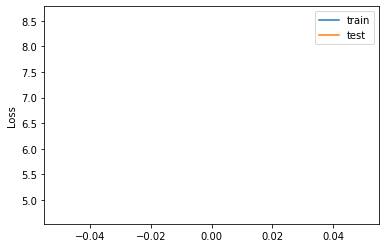

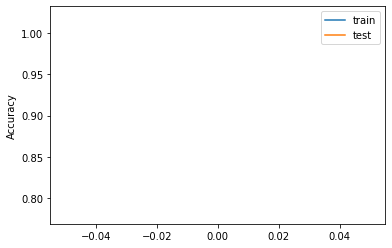


                        Experimenting on Tiny Dataset 
                        patch:1,
                        sparse_att: True,
                        sparse_mlp: True,
                        num_layers : 12,
                        seed: 147
                    
Exiting as the config is in NOT WORKING


In [10]:
### Automate the benchmark
###### for c10 / c100

not_working = [
    (1, False, False, 4),
    (1, False, False, 8),
    (1, False, False, 12),
    (1, False, True, 4),
    (1, False, True, 8),
    (1, False, True, 12),

    (1, True, False, 12),
    (1, True, True, 12),
]

cuda_idx = 0
# for seed in [147, 258, 369]:
for seed in [147]:
    for patch_size in [1]:
        for sparse_attention in [False, True]:
            for sparse_mlp in [False, True]:
                for nlayers in [4, 8, 12]:

                    print(f'''
                        Experimenting on Cifar100 Dataset 
                        patch:{patch_size},
                        sparse_att: {sparse_attention},
                        sparse_mlp: {sparse_mlp},
                        num_layers : {nlayers},
                        seed: {seed}
                    ''')
            
                ### check if config is in not_working case
                    exit = False
                    for nw in not_working:
                        if patch_size==nw[0] and \
                            sparse_attention==nw[1] and \
                            sparse_mlp==nw[2] and\
                            nlayers==nw[3]:
                            
                            exit=True
                            break
                    if exit:
                        print(f'Exiting as the config is in NOT WORKING')
                        continue


                    benchmark(dataset='cifar100', 
                              patch_size=patch_size, 
                              num_layers=nlayers, 
                              SEED=seed, 
                              sparse_att=sparse_attention, sparse_mlp=sparse_mlp, 
                              cuda=cuda_idx
                             )

In [11]:
asdasdasd

NameError: name 'asdasdasd' is not defined

In [ ]:
## Use mixing 

In [ ]:
### TODO: Experiments
'''
1. Sparse Attention
2. Sparse MLP
3. Sparse Att + MLP

Datasets:
A. Cifar-10/100 -> 4x4 vs 2x2 vs 1x1 patch
B. Tiny-Imagenet -> 16x16 vs 4x4 vs 2x2 patch
'''

In [ ]:
'''
## Cifar 10/100

vit_mixer = Mixer_ViT_Classifier((3, 32, 32), patch_size=[8, 8], hidden_channel=256, num_blocks=6, num_classes=200, block_seq_size=4, block_mlp_size=16)

vit_mixer = Mixer_ViT_Classifier((3, 32, 32), patch_size=[4, 4], hidden_channel=128, num_blocks=3, num_classes=10, block_seq_size=8, block_mlp_size=128)

vit_mixer = Mixer_ViT_Classifier((3, 32, 32), patch_size=[2, 2], hidden_channel=64, num_blocks=3, num_classes=10, block_seq_size=16, block_mlp_size=8)

vit_mixer = Mixer_ViT_Classifier((3, 32, 32), patch_size=[1, 1], hidden_channel=64, num_blocks=3, num_classes=10, block_seq_size=32, block_mlp_size=8)

'''

In [ ]:
'''
vit_mixer = Mixer_ViT_Classifier((3, 64, 64), patch_size=[4, 4], hidden_channel=128, num_blocks=9, num_classes=200, block_seq_size=16, block_mlp_size=16)
Sequence len: 256 ; Block size: 16
Channel dim: 128 num heads: 8
MLP dim: 128 ; Block size: 16


vit_mixer = Mixer_ViT_Classifier((3, 64, 64), patch_size=[8, 8], hidden_channel=256, num_blocks=9, num_classes=200, block_seq_size=8, block_mlp_size=16)
Sequence len: 64 ; Block size: 16
Channel dim: 256 num heads: 16
MLP dim: 256 ; Block size: 16

vit_mixer = Mixer_ViT_Classifier((3, 64, 64), patch_size=[16, 16], hidden_channel=1024, num_blocks=9, num_classes=200, block_seq_size=4, block_mlp_size=32)
Sequence len: 16 ; Block size: 4
Channel dim: 1024 num heads: 32
MLP dim: 1024 ; Block size: 32
'''

### Automate the model creation

In [ ]:
img = 64
patch_size = [16, 8, 4, 2, 1]
expansion = [1024, 256, 128, 64, 64]

for i in range(len(patch_size)):
    ps, exp = patch_size[i], expansion[i]
    print(i, ps, exp)
    seq_len = (img//ps)**2
    print('seq:', seq_len)
    
    fact_seq = int(2**np.ceil(np.log2(np.sqrt(seq_len))))
    print(f'fact_seq: {fact_seq}')
    
    
    fact_mlp = int(2**np.ceil(np.log2(np.sqrt(exp))))
    print(f'fact_mlp: {fact_mlp}')